In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn import set_config; set_config(display='diagram')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score,precision_score,recall_score
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [9]:
data=pd.read_csv("C:/Users/Amani/Desktop/python/titanic-passengers.csv",sep=";")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
3,568,No,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
4,672,No,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S


In [10]:
data.shape

(891, 12)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


11 features and 1 target (survived). 6 numerical features (2 floats and 4 integer) and 6 objects types (2 categorical)

In [12]:
df_nan = pd.DataFrame({'Nan':data.isna().sum()})
df_nan['%nan'] = df_nan['Nan']/data.shape[0]*100
round(df_nan,2).sort_values(by='%nan' , ascending=False)

,Nan,%nan
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00


Beaucoup de valeurs manquantes dans Cabin 

Soit on drop la colonne soit à transformer en 0/1 : 0 si NaN, 1 car les personnes avec NaN signifient qu'elles n'avaient pas de cabine 

Quelques valeurs manquantes dans Age et Embarked (peut-être à imputer)

In [23]:
data.Survived.value_counts()

No     549
Yes    342
Name: Survived, dtype: int64

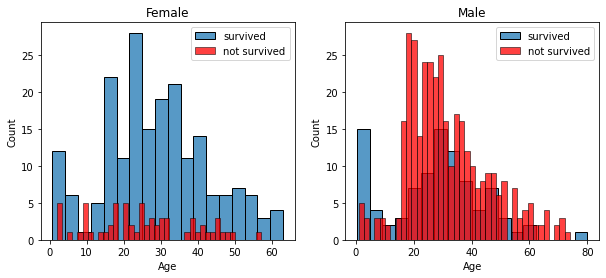

In [32]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = data[data['Sex']=='female']
men = data[data['Sex']=='male']
ax = sns.histplot(women[women['Survived']== 'Yes'].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.histplot(women[women['Survived']=='No'].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False,color='r')
ax.legend()
ax.set_title('Female')
ax = sns.histplot(men[men['Survived']=='Yes'].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.histplot(men[men['Survived']=='No'].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False,color='r')
ax.legend()
_ = ax.set_title('Male')


In [41]:
#cleanup pour remplace le yes par 1 et no par 0
cleanup={"Survived":{"Yes":1,"No":0}}
data.replace(cleanup,inplace=True)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

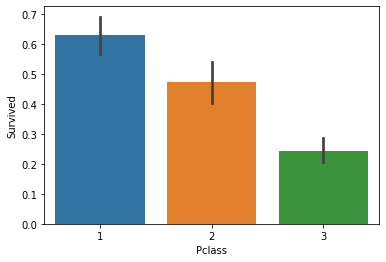

In [42]:
sns.barplot(x='Pclass', y='Survived', data=data)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

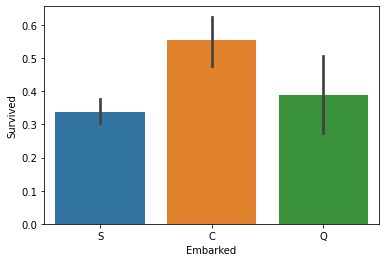

In [50]:
sns.barplot(x='Embarked', y="Survived", data=data)

<AxesSubplot:>

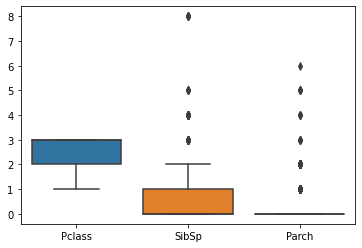

In [44]:
sns.boxplot(data=data.drop(columns=['PassengerId','Fare','Age','Survived']))

<AxesSubplot:xlabel='Fare', ylabel='Count'>

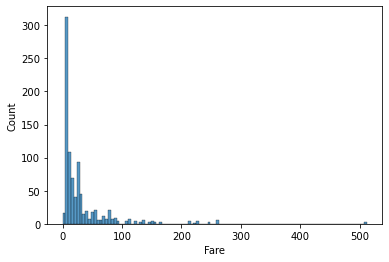

In [45]:
sns.histplot(data.Fare)

<AxesSubplot:>

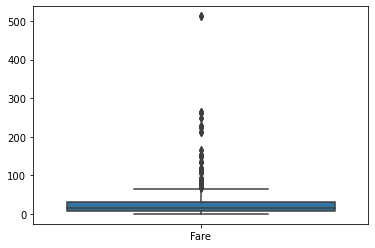

In [46]:
sns.boxplot(data=data[['Fare']])

<AxesSubplot:>

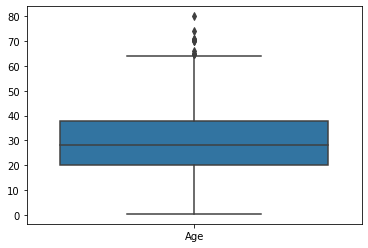

In [47]:
sns.boxplot(data=data[['Age']])

In [48]:
data.Age.min()

0.42

In [49]:
data.Age.max()

80.0

####  Preprocessing

In [53]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

In [54]:
data=data.drop(columns_to_drop,axis=1)

In [56]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [60]:
# Using Median value for Age
data['Age'].fillna(data['Age'].median(), inplace=True)

#### split data

In [79]:
X=data.drop("Survived",axis=1)
y=data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 2022,stratify=y)

In [115]:
#pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])
numeric_transformer = Pipeline(steps=[
   ('scaler',RobustScaler()),])

In [116]:
num_columns = X.columns[X.dtypes != 'object']
cat_columns = X.columns[X.dtypes == 'object']

In [117]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer,num_columns ),
        ('cat', categorical_transformer,cat_columns)
    ]
)

In [118]:
from sklearn.linear_model import LogisticRegression
logreg_pipe = Pipeline([
        ('transformer', preprocessor),
        ('classifier', LogisticRegression()),
    ])

logreg_pipe.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Sex'], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [119]:
y_pred_log=logreg_pipe.predict(X_test)

In [120]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print(classification_report(y_test,y_pred_log))
print(confusion_matrix(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       137
           1       0.74      0.74      0.74        86

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223

[[115  22]
 [ 22  64]]


In [121]:
print('Accuracy: ', accuracy_score(y_test, y_pred_log))

Accuracy:  0.8026905829596412


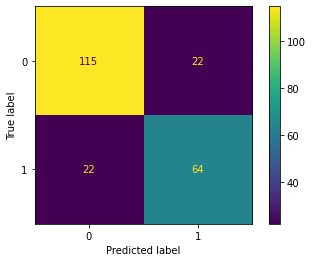

In [122]:
cfm=confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=logreg_pipe.classes_)
disp.plot() 

#### Courbe ROC AUC

Courbe ROC ASC
Une autre façon d'évaluer et de comparer votre classificateur binaire est fournie par la courbe ROC AUC. Cette courbe trace le taux de vrais positifs  par rapport au taux de faux positifs (rapport d'instances négatives mal classées)
AUC L'aire sous la courbe ROC, aussi notée AUC (de l'anglais Area Under the Curve) ou AUROC (de l'anglais Area Under the ROC)

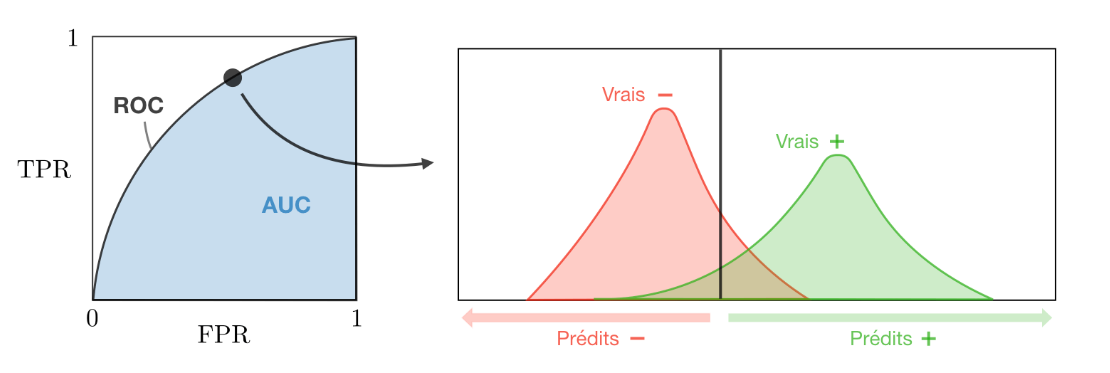

L’aire sous la courbe ROC est donc un indicateur de la performance globale du modèle, et est compris entre deux bornes :

50%   AUC ROC d’un modèle de Machine Learning  100%

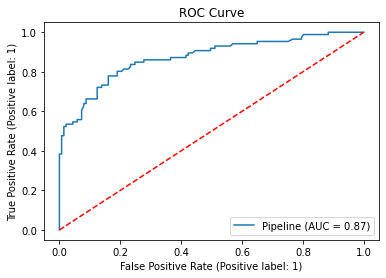

In [123]:
# ROC Curve
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
plot_roc_curve(logreg_pipe, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()